In [ ]:
# importing libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Load content and style images
from google.colab import files
content = files.upload()
style = files.upload()

In [ ]:
content_image_path = "/content/content.jpg" # Replace with your content image
style_image_path = "/content/style.jpg"  # Replace with your style image# Load and preprocess images
def load_and_process_image(image_path, target_size=(400, 400)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [ ]:
target_size = (400, 400)
content_image = load_and_process_image(content_image_path, target_size)
style_image = load_and_process_image(style_image_path, target_size)

In [ ]:
# Load VGG19 model (pre-trained on ImageNet)
vgg = vgg19.VGG19(weights='imagenet', include_top=False)
vgg.trainable = False

# Extract features from intermediate layers
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layer = 'block4_conv2'
layers = style_layers + [content_layer]
model_outputs = [vgg.get_layer(layer).output for layer in layers]
model = Model(inputs=vgg.input, outputs=model_outputs)

In [ ]:
# Compute content loss
def compute_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Compute gram matrix for style loss
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    matrix = tf.reshape(tensor, [-1, channels])
    gram = tf.matmul(tf.transpose(matrix), matrix)
    return gram

# Compute style loss
def compute_style_loss(base_style, gram_target):
    gram_base = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_base - gram_target))

# Get feature representations
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_process_image(content_path, target_size)
    style_image = load_and_process_image(style_path, target_size)
    content_features = model(content_image)
    style_features = model(style_image)
    return content_features, style_features

# Compute losses and gradients
# Compute losses and gradients
def compute_loss_and_grads(model, content_features, style_features, generated_image):
    with tf.GradientTape() as tape:
        generated_features = model(generated_image)
        content_loss = compute_content_loss(generated_features[-1], content_features[-1])

        # Calculate Gram matrices for style features *before* the loop
        style_gram_matrices = [gram_matrix(feature) for feature in style_features[:-1]]  # Exclude content feature

        style_loss = tf.add_n([compute_style_loss(generated_features[i], style_gram_matrices[i]) for i in range(len(style_layers))])
        total_loss = content_loss * 1.0 + style_loss * 1e-4
    grads = tape.gradient(total_loss, generated_image)
    return total_loss, grads

In [ ]:
# Run optimization
content_features, style_features = get_feature_representations(model, content_image_path, style_image_path)
generated_image = tf.Variable(content_image, dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=5.0)

In [ ]:
# Deprocess image (convert from VGG19 format to normal image)
def deprocess_image(img):
    img = img.reshape((400, 400, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]  # Convert BGR to RGB
    img = np.clip(img, 0, 255).astype('uint8')
    return img

Iteration 0: Loss = 270327976296448.0
Iteration 1: Loss = 192072850079744.0
Iteration 2: Loss = 144256190644224.0
Iteration 3: Loss = 107660972130304.0
Iteration 4: Loss = 85982661574656.0
Iteration 5: Loss = 76685391167488.0
Iteration 6: Loss = 73781456404480.0
Iteration 7: Loss = 72539984363520.0
Iteration 8: Loss = 70102179381248.0
Iteration 9: Loss = 65651548880896.0
Iteration 10: Loss = 59782123749376.0
Iteration 11: Loss = 53605855920128.0
Iteration 12: Loss = 48013569425408.0
Iteration 13: Loss = 43403857362944.0
Iteration 14: Loss = 39744394231808.0
Iteration 15: Loss = 36771840655360.0
Iteration 16: Loss = 34214791610368.0
Iteration 17: Loss = 31939348135936.0
Iteration 18: Loss = 29954169372672.0
Iteration 19: Loss = 28304211968000.0
Iteration 20: Loss = 26937902759936.0
Iteration 21: Loss = 25687977099264.0
Iteration 22: Loss = 24399902146560.0
Iteration 23: Loss = 23030738714624.0
Iteration 24: Loss = 21624667504640.0
Iteration 25: Loss = 20268063916032.0
Iteration 26: Loss

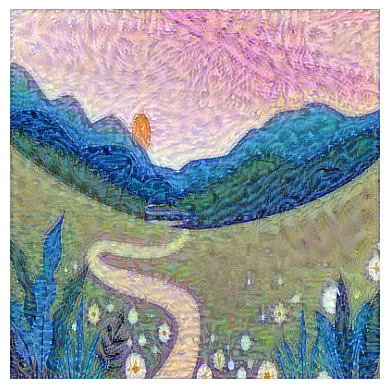

In [ ]:
# Training loop
iterations = 42
for i in range(iterations):
    loss, grads = compute_loss_and_grads(model, content_features, style_features, generated_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(f"Iteration {i}: Loss = {loss.numpy()}")
    if i == iterations - 1:
        output_image = deprocess_image(generated_image.numpy())
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()